<a href="https://colab.research.google.com/github/LilianYou/dark-lily/blob/master/6_deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import io, requests
import tqdm
import scipy.ndimage as nd
import numpy as np
from torchvision import transforms
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [0]:
at_layer = 27
network = models.vgg19(pretrained=True)
layers = list(network.features.children())
model = nn.Sequential(*layers[: (at_layer + 1)]).cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
response = requests.get("https://services.ini.uzh.ch/admin/extras/img_view.php?id=9871")
img_pil = Image.open(io.BytesIO(response.content))
image = preprocess(img_pil).unsqueeze(0).cpu().data.numpy()
image_t = Variable(Tensor(image), requires_grad=True)


In [0]:
def opt_input(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        #The following is a custom optimization step
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


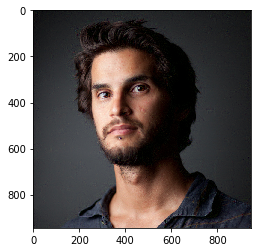

In [0]:
plt.imshow(deprocess(opt_input(image_t, model, 5, .01)))

In [0]:
num_octaves=10
octave_scale=1.4
octaves = [image]
for _ in range(num_octaves - 1):
    octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

In [0]:
deprocess(octaves[-1])

(46, 46, 3)

In [0]:
detail = np.zeros_like(octaves[-1])
for octave, octave_base in enumerate(octaves[::-1]):
    if octave > 0:
        # Upsample detail to new octave dimension
        detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
    # Add deep dream detail from previous octave to new base
    input_image = octave_base + detail
    # Get new deep dream image
    dreamed_image = opt_input(input_image, model, 20, lr=.01)
    # Extract deep dream details
    detail = dreamed_image - .97*octave_base

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


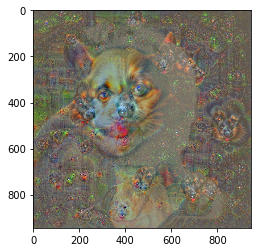

In [0]:
plt.imshow(deprocess(detail))